
# PlantEye F500 Technology Overview

The **PlantEye F500** is an advanced 3D multispectral plant scanner developed by Phenospex. It is designed to capture detailed morphological and physiological data from plants in a non-invasive, high-throughput manner. This technology is widely used in plant phenotyping, agriculture research, and precision farming.

## Key Features

- **3D Laser Scanning**: The F500 uses laser triangulation to generate accurate 3D point clouds of plant canopies. This allows for detailed measurements of plant structure, including height, leaf area, and volume.

- **Multispectral Imaging**: The device integrates multispectral sensors that capture reflectance in several wavelengths (typically Red, Green, Blue, and Near-Infrared). This enables the calculation of vegetation indices such as NDVI, and NPCI.

- **High Throughput**: The F500 can scan large numbers of plants quickly, making it suitable for field-based phenotyping and automated greenhouse systems.

- **Environmental Adaptability**: Designed for both controlled environments (greenhouses, growth chambers) and outdoor use, the scanner compensates for variable lighting conditions and can operate under various weather scenarios.

- **Data Integration**: PlantEye F500 data is typically output in 3D point clouds and .csv formats, which include spatial coordinates (x, y, z), spectral values (R, G, B, NIR), and derived indices. This makes it compatible with a wide range of data analysis tools and programming environments.

## Output Data

The F500 generates comprehensive datasets that can be used for scientific research and agricultural decision-making. Each scan typically includes:

- 3D point cloud data (x, y, z)
- Spectral reflectance values (R, G, B, NIR)
- Vegetation indices (e.g., NDVI, NPCI)
- Derived traits such as plant height, projected leaf area, and volume

## Data Processing at NPEC

The **Netherlands Plant Eco-phenotyping Centre (NPEC)** utilizes open-source software tools to process and analyze data generated by the PlantEye F500. These tools focus on extracting meaningful biological insights from the rich 3D point cloud data and associated multispectral measurements.

### Index Calculation and Histograms

NPEC's data pipeline includes software that computes various **vegetation indices** from the 3D point clouds. These indices—such as NDVI (Normalized Difference Vegetation Index) and NPCI (Normalized Pigment Chlorophyll Index)—provide quantitative indicators of plant health, biomass, and physiological status.

Additionally, **histograms** are generated to represent the distribution of these indices across the scanned plant area. These visualizations help in identifying variations and patterns in plant traits, and they serve as useful diagnostic tools for phenotyping.

### Metadata Management with ISA-JSON

To ensure reproducibility and semantic interoperability, all experimental metadata is stored using the **ISA-JSON** format. ISA (Investigation-Study-Assay) is a standardized metadata framework widely adopted in life sciences. In this context, the ISA-JSON files contain crucial information about:

- The experiment setup
- Plant and treatment details
- Links to raw and processed data

These metadata files will be used within this notebook to **load, visualize, and analyze** the corresponding datasets. This integration ensures that each analysis step is traceable and properly contextualized with respect to the original experimental design.


## Setup

Please set `threshold_date` to the start of the experiment. In some case there were trial measurements which you don't need to use your analysis.

### 🧪 **Overview of the Code Block**

This part of the notebook sets up the tools and data needed for analyzing a plant phenotyping experiment. It prepares the environment to read both the measurements and the metadata collected during the experiment.

---

### 🔧 **What Each Section Does**

#### 1. **Importing Tools (Libraries)**

```python
import ...
```

This section loads Python *libraries*, which are like toolboxes. Each one has a specific purpose:

* `json`, `os`: For handling files and data formats.
* `isatools`: For working with ISA-JSON metadata files, which store experimental descriptions.
* `pandas`, `numpy`: For organizing and processing tables of data (like spreadsheets).
* `matplotlib`, `seaborn`: For making charts and graphs.
* `datetime`, `PIL`: For working with dates and images.

You don't need to know the details of each, but think of them as helpers to handle different parts of your data and analysis.

#### 2. **Specifying Where the Data Lives**

```python
isa_json = "...json"
metadata_file = "...csv"
data_folder = "..."
threshold_date = ...
```

This section defines the *paths* (locations on your computer or server) where the files are stored:

* `isa_json`: The main **metadata file** (in ISA-JSON format) that describes your experiment.
* `metadata_file`: A **CSV file** that includes plant-level information, like pot IDs or treatments.
* `data_folder`: The general folder where data files are stored.
* `threshold_date`: A specific date used later, possibly to filter out older data.

#### 3. **Loading the Experiment Metadata**

```python
investigation = isajson.load(open(isa_json, "r"))
study = investigation.studies[0]
```

This reads the ISA-JSON file and pulls out the *first study* described in the experiment. This metadata includes information like treatments, instruments used, and timing.

#### 4. **Reading the Plant Metadata Table**

```python
metadata = pd.read_csv(metadata_file, delimiter = ";", engine = "python")
```

This reads the CSV file into a table (called a *DataFrame* in Python) so that it can be used in analysis.

#### 5. **Tidying Up the Table**

```python
metadata[['Pot']] = metadata['DataMatrix'].str.split(" ", expand=True)
metadata = metadata.drop('DataMatrix', axis=1)
```

These lines clean up the metadata table:

* They split one column (`DataMatrix`) into separate parts to isolate the `Pot` ID.
* Then they remove the original `DataMatrix` column since it's no longer needed.

---

### 🌱 **Why This Matters**

This setup ensures:

* You can link measurement data with the correct experimental treatments.
* You have clear and clean metadata, ready to be used for analysis and visualization.
* Everything is traceable, thanks to the structured ISA-JSON format.



In [ ]:

import json
import os
from isatools.isajson import ISAJSONEncoder
import isatools
from isatools.model import *
from isatools import isajson

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
from PIL import Image

isa_json = "/data2/npec/notebook_data/NPEC_Potdata_Gantry3_exp29_running.csv.json"
metadata_file = "/data2/npec/notebook_data/running_exp29_Gantry3/exp29/metadata/NPEC_Potdata_Gantry3_exp29_running.csv"
data_folder = "/data2/npec/notebook_data/"
threshold_date = dt.datetime(2021, 1, 1)


investigation = isajson.load(open(isa_json, "r"))
study = investigation.studies[0]

metadata = pd.read_csv(metadata_file, delimiter = ";", engine = "python")
metadata[['Pot']] = metadata['DataMatrix'].str.split(" ", expand=True)
metadata = metadata.drop('DataMatrix', axis=1)


## Phenotopic data

### 🧬 **What This Code Does: Reading Phenotypic Data**

```python
phenotypic_data_list = []
```

This creates an empty list to store the phenotypic data tables as they are read from files.

#### 🔁 Looping Through the Assays

```python
for assay in study.assays:
```

This goes through each **assay** in your study. In ISA metadata, an "assay" typically refers to one measurement activity—like scanning plants on a specific date.

##### Getting Sample Info

```python
    sample_name = assay.samples[0].name
    timepoint = assay.filename
    title = assay.filename
```

These lines pull out information about the assay:

* `sample_name`: the name of the sample being measured.
* `timepoint` and `title`: here, both are based on the filename, which likely encodes the date or condition of the scan.

##### Looping Through Data Files

```python
    for df in assay.data_files:
        for com in df.comments:
            if com.name == "fullPath" and "/" + title + ".csv" in com.value:
```

Each assay can have multiple files. This loop:

* Looks through each file linked to the assay.
* Checks the **comments** attached to the file to find the one that contains the full path to the relevant CSV file with phenotypic data.
* It matches based on the title (e.g., `"scan_2021-04-01.csv"`).

##### Reading and Storing Data

```python
                assay_data = pd.read_csv(data_folder + com.value, header=0, delimiter=";")
                phenotypic_data_list.append(assay_data)
```

Once it finds the correct file, it:

* Reads it into a **dataframe** (like a spreadsheet in Python).
* Appends it to the list of all assay data.

---

### 📊 **Combining and Merging the Data**

```python
phenotypic_data = pd.concat(phenotypic_data_list, axis=0, ignore_index=True)
```

This stacks all the data from each assay into **one large table**. It resets the row numbers to keep things clean.

```python
phenotypic_data = pd.merge(phenotypic_data, metadata, on='Pot')
```

Finally, it **merges** the phenotypic data with the earlier metadata table using the `Pot` ID. This means each measurement will now include information like plant variety, treatment, and position—essential context for analysis.

---

### 🌿 **Why This Is Important**

* It **automatically finds and reads** all relevant measurement files.
* It organizes the data into one unified table that’s ready for analysis.
* It connects each measurement to its biological context (via metadata).
* It follows best practices for reproducibility by relying on the metadata defined in the ISA-JSON structure.

---

### 📝 Summary for Plant Researchers

This part of the notebook pulls together **all trait measurements** (like height, leaf area, indices) taken during the experiment. It reads the data from individual files for each scanning session and combines them into one complete dataset. Then it enriches that data with information about each plant’s identity and treatment. This makes it ready for visualization, statistical analysis, or export.



In [3]:
phenotypic_data_list = []
for assay in study.assays:
    sample_name = assay.samples[0].name
    timepoint = assay.filename
    title = assay.filename

    for df in assay.data_files:
        for com in df.comments:
            if com.name == "fullPath" and "/" + title + ".csv" in com.value:
                assay_data = pd.read_csv(data_folder + com.value, header=0, delimiter=";")
                phenotypic_data_list.append(assay_data)
                    
phenotypic_data = pd.concat(phenotypic_data_list, axis=0, ignore_index=True)

phenotypic_data = pd.merge(phenotypic_data, metadata, on='Pot')

## Formatting data

### 🧼 **Cleaning and Formatting the Phenotypic Data**

Once the phenotypic measurements have been loaded, they often require additional formatting before they can be used in analysis. This code block prepares the dataset by correcting timestamps, filtering by date, and creating useful new columns.

---

### 🧩 **Explanation of Each Step**

#### 🔧 1. **Creating a Combined Column**

```python
def concatenate_columns(row, x, y):
    return f"{row[x]}, {row[y]}"
```

This defines a small helper function. It takes a row of data and joins the values from two columns (like `Treatment` and `Genotype`) into one string, separated by a comma. For example:

```
"Control, Wild-type"
```

---

#### 🔄 2. **Fixing Column Names After Merge**

```python
phenotypic_data["Treatment"] = phenotypic_data["Treatment_y"]
```

After merging the phenotypic data with the metadata, there may be multiple `Treatment` columns. This line picks the correct one (`Treatment_y`) and standardizes its name to just `Treatment`.

---

#### 🕒 3. **Parsing the Timestamps**

```python
phenotypic_data["timestamp"]= phenotypic_data["timestamp"].apply(lambda x: dt.datetime.strptime(x, '%Y%m%dT%H%M%S'))
```

The original timestamps (recorded as plain text like `20210421T093015`) are converted into proper Python **datetime** objects. This allows for accurate filtering and time-based analysis later.

---

#### 📅 4. **Extracting Date and Hour**

```python
phenotypic_data["day"] = phenotypic_data["timestamp"].dt.date
phenotypic_data['timestamp_hourly'] = phenotypic_data['timestamp'].dt.floor('h')
```

These two lines:

* Extract just the **calendar date** (used to group measurements by day).
* Round the timestamp down to the **nearest full hour**, which is useful for summarizing data collected at different moments.

---

#### ⏳ 5. **Filtering by a Start Date**

```python
phenotypic_data = phenotypic_data[phenotypic_data["timestamp"] >= threshold_date]
```

This removes any measurements that were taken before a specified start date (`threshold_date`), likely to focus the analysis on a specific experimental window.

---

#### 🧬 6. **Creating a Composite Label**

```python
phenotypic_data["Treatment, genotype"] =  phenotypic_data.apply(concatenate_columns, axis=1, x='Treatment', y='Genotype')
```

This uses the earlier helper function to create a new column called `"Treatment, genotype"`, which combines both pieces of information into a single label. This is useful for grouping or coloring plots later on.

---

### 📌 **Why This Matters**

* Makes **time information usable** for analysis (by converting to datetime).
* Prepares the data for **time-series plots**, daily summaries, and condition-based grouping.
* Ensures that the data reflects only the **relevant experimental period**.
* Simplifies visualization and statistical grouping with a combined treatment/genotype label.

---

### 👩‍🔬 Summary for Researchers

This step cleans up the dataset by formatting time data, removing older entries, and creating combined labels for easier grouping in plots and analyses. It's a crucial part of making raw measurement data ready for meaningful biological interpretation.



In [4]:
def concatenate_columns(row, x, y):
    return f"{row[x]}, {row[y]}"

phenotypic_data["Treatment"] = phenotypic_data["Treatment_y"]
phenotypic_data["timestamp"]= phenotypic_data["timestamp"].apply(lambda x: dt.datetime.strptime(x, '%Y%m%dT%H%M%S'))
phenotypic_data["day"] = phenotypic_data["timestamp"].dt.date
phenotypic_data['timestamp_hourly'] = phenotypic_data['timestamp'].dt.floor('h')
phenotypic_data = phenotypic_data[phenotypic_data["timestamp"] >= threshold_date]

phenotypic_data["Treatment, genotype"] =  phenotypic_data.apply(concatenate_columns, axis=1, x='Treatment', y='Genotype')

## Summary

### 📋 **Summary of Phenotypic Dataset**

This code block provides a clean, readable summary of the dataset you’ve just prepared. It's designed to help researchers quickly understand the scope and content of their phenotypic data before deeper analysis or visualization.

---

### 🧾 **What the Code Does**

#### 1. **Imports a Display Tool**

```python
from IPython.display import display, Markdown
```

This allows the notebook to show output in **Markdown format**, which makes it easier to read than plain text.

---

#### 2. **Calculates Key Statistics**

```python
num_data_points = len(phenotypic_data["timestamp"])
genotypes = phenotypic_data["Genotype"].unique()
num_genotypes = len(genotypes)
max_height = phenotypic_data["height_max"].dropna().max()
min_max_height = phenotypic_data["height_max"].dropna().min()
avg_max_height = phenotypic_data["height_max"].dropna().mean()
treatments = phenotypic_data["Treatment"].unique()
start_date = phenotypic_data["timestamp"].min()
end_date = phenotypic_data["timestamp"].max()
samples = phenotypic_data["Pot"].unique()
```

This section gathers various summary statistics:

* Number of individual measurements
* List and count of different **genotypes**
* Maximum, minimum, and average of **maximum plant heights**
* List of all **treatments**
* Start and end date of the experiment (based on timestamps)
* List of unique **pots** (samples)

---

#### 3. **Creates a User-Friendly Summary**

```python
summary_text = f"""..."""
display(Markdown(summary_text))
```

Here, the summary is formatted as a human-readable block using Markdown. This makes it easier to read in a notebook and more suitable for reports or sharing with collaborators.

---

### 🔍 **Why This Is Useful for Researchers**

* Gives a **quick overview** of the experimental dataset.
* Helps **verify** that the data has been read and interpreted correctly.
* Allows researchers to **spot potential issues early** (e.g., missing height data, unexpected dates).
* Provides **context** for more detailed plots and statistical analyses.

---

### 📝 Example Output

```
🌿 Phenotypic Dataset Summary

- Total number of measurements: 1248
- Number of unique genotypes: 6
- List of genotypes: WT, Mut1, Mut2, ...
- Maximum recorded plant height: 412.67 mm
- Minimum of maximum plant heights: 58.00 mm
- Average of maximum plant heights: 193.46 mm
- Treatments applied: Control, Drought
- Measurement period: From 2021-04-01 09:00 to 2021-04-15 18:00
- Number of unique pots (samples): 72
```


In [5]:
from IPython.display import display, Markdown

# Gather values
num_data_points = len(phenotypic_data["timestamp"])
genotypes = phenotypic_data["Genotype"].unique()
num_genotypes = len(genotypes)
max_height = phenotypic_data["height_max"].dropna().max()
min_max_height = phenotypic_data["height_max"].dropna().min()
avg_max_height = phenotypic_data["height_max"].dropna().mean()
treatments = phenotypic_data["Treatment"].unique()
start_date = phenotypic_data["timestamp"].min()
end_date = phenotypic_data["timestamp"].max()
samples = phenotypic_data["Pot"].unique()

# Display formatted summary
summary_text = f"""
### 🌿 Phenotypic Dataset Summary

- **Total number of measurements:** {num_data_points}
- **Number of unique genotypes:** {num_genotypes}
- **List of genotypes:** {', '.join(genotypes)}
- **Maximum recorded plant height:** {max_height:.2f} mm
- **Minimum of maximum plant heights:** {min_max_height:.2f} mm
- **Average of maximum plant heights:** {avg_max_height:.2f} mm
- **Treatments applied:** {', '.join(treatments)}
- **Measurement period:** From **{start_date.strftime('%Y-%m-%d %H:%M')}** to **{end_date.strftime('%Y-%m-%d %H:%M')}**
- **Number of unique pots (samples):** {len(samples)}
"""

display(Markdown(summary_text))



### 🌿 Phenotypic Dataset Summary

- **Total number of measurements:** 348
- **Number of unique genotypes:** 2
- **List of genotypes:** G1, G2
- **Maximum recorded plant height:** 408.75 mm
- **Minimum of maximum plant heights:** 0.00 mm
- **Average of maximum plant heights:** 238.17 mm
- **Treatments applied:** T1, T2
- **Measurement period:** From **2023-06-23 10:04** to **2023-07-09 12:03**
- **Number of unique pots (samples):** 12


## 🌿 **Explanation of Measured Traits from PlantEye F500**

The **PlantEye F500** uses 3D laser scanning and multispectral imaging to non-destructively assess various morphological and physiological traits of plants. The following traits are derived from the **3D point clouds** generated during each scan:

---

### 📏 **1. Height (`height`)**

* **What it is:** The vertical distance from the ground to the highest point of the plant canopy.
* **How it's measured:** Calculated directly from the 3D point cloud by identifying the highest z-coordinate in the plant's scanned area.
* **Why it's useful:** A primary indicator of plant growth over time and response to environmental conditions or treatments.

---

### 🌱 **2. Digital Biomass (`digital_biomass`)**

* **What it is:** An estimate of plant biomass based on the volume and density of the 3D point cloud.
* **How it's measured:** Derived using the number and distribution of 3D points that represent the plant. It often correlates with actual biomass measured destructively.
* **Why it's useful:** Provides a non-destructive approximation of total plant growth, which is crucial for longitudinal studies and high-throughput phenotyping.

---

### 📐 **3. Leaf Inclination (`leaf_inclination`)**

* **What it is:** The average **tilt angle** of the leaves relative to the vertical axis.
* **How it's measured:** Calculated using the orientation of 3D surface normals in the point cloud, which indicate how steeply the leaves are angled upward or outward.
* **Why it's useful:** Reflects the plant's light interception strategy. More upright leaves can indicate different photosynthetic or stress-adaptive behavior.

---

### 🔄 **4. Leaf Angle (`leaf_angle`)**

* **What it is:** Often refers to the angle between a leaf surface and the horizontal plane.
* **How it's measured:** Similar to leaf inclination, but this metric may average angles more broadly across the canopy or use a different reference axis.
* **Why it's useful:** A sensitive indicator of plant response to environmental stresses (e.g., drought or light competition), as leaf posture can change in reaction to water availability or light direction.

---

### 🔬 **Why These Traits Matter**

These measurements together provide a **multi-dimensional view of plant growth**:

* **Height and digital biomass** tell you about **size and structural development**.
* **Leaf inclination and angle** tell you about **architecture and physiological responses**.

All are captured automatically and non-destructively by the PlantEye F500, enabling repeated measurements over time with high throughput.



## Plotting functions

### 📈 **Visualization Functions for Phenotypic Traits**

These two functions—`plotGenotypes()` and `plotTreatment()`—are designed to help researchers visualize how key plant traits evolve over time, grouped either by **genotype** or **treatment**.

Each plot shows one trait over time (using hourly timestamps), with lines grouped by individual plants, genotypes, or treatments.

---

## 🌿 `plotGenotypes()`

### 🔧 **Function Purpose**

This function generates **line plots** of selected traits for one or more genotypes, over time. It allows comparison between different genotypes within the experiment.

### 📥 **Inputs**

* `Experiment`: the full phenotypic dataset (a DataFrame).
* `Genotypes`: a list of genotype names to plot (e.g., `["WT", "Mut1"]`).
* `hue`: determines what variable is used to color the lines (default is `"Genotype"`).

### 📊 **Traits Plotted**

* `digital_biomass`
* `height`
* `leaf_inclination`
* `leaf_angle`

### 📌 **How It Works**

1. Filters the dataset to include only the selected genotypes.
2. For each trait:

   * Draws a line plot with time on the x-axis and the trait on the y-axis.
   * Colors the lines by the `hue` variable (e.g., genotype or individual plant).
3. Displays each trait in a separate plot.

### 🖼️ **Example Use**

```python
plotGenotypes(phenotypic_data, ["WT", "Mut1"])
```

---

## 🌱 `plotTreatment()`

### 🔧 **Function Purpose**

This function visualizes plant traits over time, grouped by treatment (e.g., `"Control"` vs `"Drought"`). It helps researchers observe how treatments affect plant development.

### 📥 **Inputs**

* `Experiment`: the phenotypic dataset.
* `Treatment`: a list of treatment names to include in the plots.
* `hue`: determines what variable is used to color the lines (default is `"Pot"` to see each plant individually).

### 📊 **Traits Plotted**

Same as above:

* `digital_biomass`
* `height`
* `leaf_inclination`
* `leaf_angle`

### 📌 **How It Works**

1. Filters the data to only include the selected treatments.
2. Plots each trait over time, coloring lines by the selected `hue` (default is individual plant).
3. Rotates x-axis labels for better readability.

### 🖼️ **Example Use**

```python
plotTreatment(phenotypic_data, ["Control", "Drought"])
```

---

### 🎯 **Why These Functions Matter**

* Enable quick **visual inspection** of how plant traits vary across genotypes or treatments.
* Facilitate **exploratory data analysis** before running statistical tests.
* Offer **customizable groupings** through the `hue` argument (e.g., color by genotype, pot, or treatment).



In [6]:
def plotGenotypes(Experiment, Genotypes, hue="Genotype"):
    Genotypes = list(Genotypes)

    traits = ["digital_biomass", "height", "leaf_inclination", "leaf_angle"]
    filtered = Experiment[Experiment['Genotype'].isin(Genotypes)]

    for trait in traits:
        sns.lineplot(
            data=filtered,
            x="timestamp_hourly",
            y=trait,
            hue=hue,
            palette="colorblind"
        )
        plt.title(f"Plant {trait.replace('_', ' ')}, colored by {hue}")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

def plotTreatment(Experiment, Treatment, hue="Pot"):
    Treatment = list(Treatment)  # ensure it's 1D

    for trait in ["digital_biomass", "height", "leaf_inclination", "leaf_angle"]:
        sns.lineplot(
            data=Experiment[Experiment['Treatment'].isin(Treatment)],
            x="timestamp_hourly",
            y=trait,
            hue=hue,
            palette="colorblind"
        )
        plt.title(f"Plant {trait.replace('_', ' ')}, colored by {hue}")
        plt.xticks(rotation=90)
        plt.show()



## Plot traits grouped by treatment

```python
plotTreatment(phenotypic_data, phenotypic_data["Treatment"].unique(), hue="Pot")
```

---

### 🔍 **What This Call Does**

This line of code uses the `plotTreatment()` function to **visualize plant traits over time**, grouped by **treatment** and colored by **individual pots** (i.e., each plant).

---

### 📥 **Arguments Explained**

* `phenotypic_data`: This is your cleaned dataset that contains all the measured traits, timestamps, metadata, and more.

* `phenotypic_data["Treatment"].unique()`: This dynamically gets a list of all **treatment conditions** in your dataset (e.g., `["Control", "Drought"]`), ensuring that **every treatment** in the experiment is included in the plots.

* `hue="Pot"`: This tells the plotting function to color each line by the **individual plant pot**. This allows you to see how **each specific plant** responded under its treatment.

---

### 📊 **What You'll See**

For each of the following traits:

* `digital_biomass`
* `height`
* `leaf_inclination`
* `leaf_angle`

You'll get a **line plot** where:

* The x-axis shows time (`timestamp_hourly`)
* The y-axis shows the trait value
* Each line represents a **different plant**
* The color identifies which plant (pot) it is
* The title indicates which trait is being plotted and that it's colored by `"Pot"`

Each trait is shown in a **separate plot**, and all treatments are included side by side.

---

### 🧪 **Why Use This**

* Allows you to **visually compare** how individual plants responded to different treatments.
* Helps detect **outliers**, inconsistencies, or trends in how specific traits changed over time.
* Offers insights into **plant variability** within treatments—key for understanding treatment effects.


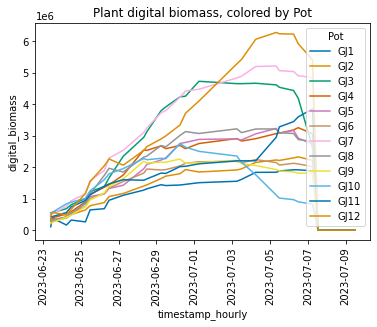

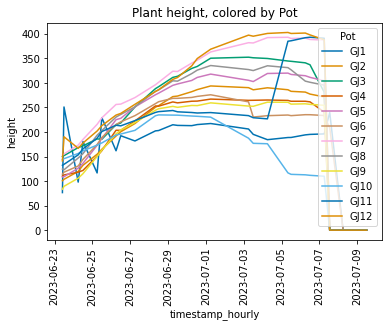

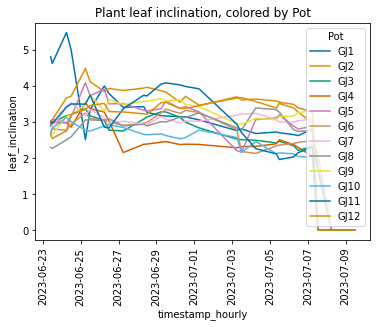

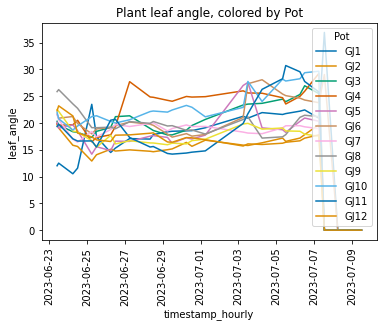

In [7]:
plotTreatment(phenotypic_data, phenotypic_data["Treatment"].unique(), hue="Pot")

## Plot traits grouped by genotype

```python
plotGenotypes(phenotypic_data, phenotypic_data["Genotype"].unique(), hue="Treatment")
```

---

### 🔍 **What This Call Does**

This line visualizes how plant traits change over time **for all genotypes**, with each line **colored by treatment**.

---

### 📥 **Arguments Explained**

* `phenotypic_data`: The full dataset containing measurements, timestamps, genotypes, treatments, and calculated traits.

* `phenotypic_data["Genotype"].unique()`: This automatically collects all **distinct genotypes** in the dataset (e.g., `["WT", "Mut1", "Mut2"]`). It ensures that **every genotype** in the study is included in the visualization.

* `hue="Treatment"`: Instead of coloring lines by genotype or pot, this colors them by **treatment condition** (e.g., `"Control"` or `"Drought"`). This lets you easily compare how treatments affect plants **within each genotype**.

---

### 📊 **What You'll See**

For each of the following traits:

* `digital_biomass`
* `height`
* `leaf_inclination`
* `leaf_angle`

You will get a separate **line plot** where:

* The x-axis shows the time (`timestamp_hourly`)
* The y-axis shows the trait values
* The data is filtered to include **all genotypes**
* Each line represents a plant, and the **line color shows which treatment** that plant received
* The title indicates the trait and that it's colored by `"Treatment"`

---

### 🌱 **Why This Is Useful**

* Helps you compare **treatment effects within each genotype** across time.
* Useful for evaluating if **certain genotypes respond differently** to stress, nutrient regimes, etc.
* Makes it easy to spot **divergent trends**—for example, if one genotype maintains growth under drought, while another declines.

---

### 🧪 Example Interpretation

If you see:

* All lines for one genotype in the `"Drought"` treatment drop in `digital_biomass`, while the `"Control"` lines rise steadily, this might suggest that genotype is **sensitive to drought**.
* Another genotype might show similar trends across treatments, suggesting **tolerance or resistance**.


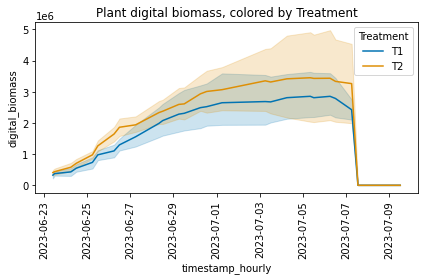

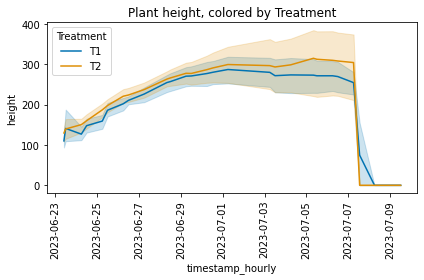

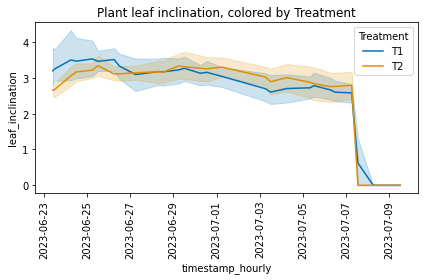

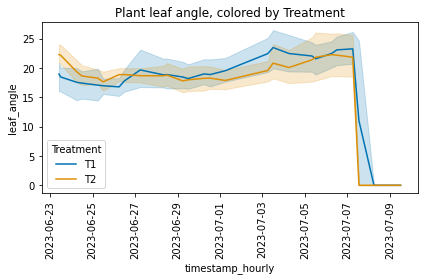

In [8]:
plotGenotypes(phenotypic_data, phenotypic_data["Genotype"].unique(), hue="Treatment")

## 🌾 Vegetation Indices Provided by PlantEye F500

Vegetation indices are mathematical combinations of spectral reflectance values (typically in the Red, Green, Blue, and Near-Infrared wavelengths) that provide insights into plant physiology, health, and stress status. The following indices are calculated directly from the multispectral data captured by the PlantEye F500:

---

### 🌿 1. **Greenness Index**
- **Purpose:** Measures the relative contribution of green light reflectance to overall reflectance, indicating general "greenness" of vegetation.
- **Formula:**  
  \[
  \text{Greenness} = \frac{G}{R + G + B}
  \]
- **Where:**
  - \( G \): Green reflectance
  - \( R \): Red reflectance
  - \( B \): Blue reflectance
- **Interpretation:** Higher values generally correspond to healthy, green plant tissue.

---

### 🌱 2. **Normalized Difference Vegetation Index (NDVI)**
- **Purpose:** A widely used index for estimating vegetation health and biomass.
- **Formula:**  
  \[
  \text{NDVI} = \frac{NIR - R}{NIR + R}
  \]
- **Where:**
  - \( NIR \): Near-Infrared reflectance
  - \( R \): Red reflectance
- **Interpretation:** Values range from -1 to 1.
  - Healthy vegetation typically has NDVI > 0.5
  - Bare soil or stressed vegetation has NDVI near 0 or negative

---

### 🍂 3. **Plant Senescence Reflectance Index (PSRI)**
- **Purpose:** Detects leaf senescence (aging), linked to pigment degradation (e.g., chlorophyll breakdown).
- **Formula:**  
  \[
  \text{PSRI} = \frac{R - G}{NIR}
  \]
- **Where:**
  - \( R \): Red reflectance
  - \( G \): Green reflectance
  - \( NIR \): Near-Infrared reflectance
- **Interpretation:** Higher values indicate increased senescence.

---

### 🎨 4. **Hue**
- **Purpose:** Represents the **dominant color** of the plant surface in HSV (Hue, Saturation, Value) color space.
- **Formula:**  
  Calculated from RGB reflectance values using standard color-space conversion.
- **Interpretation:**  
  Hue values range from 0–360°, where:
  - Green ~ 90–150°
  - Yellow/Orange ~ 30–60°
  - Red ~ 0–30° or 330–360°
- Useful for detecting color changes due to stress or senescence.

---

### 🌕 5. **Normalized Pigment Chlorophyll Index (NPCI)**
- **Purpose:** Estimates pigment composition, especially the chlorophyll to carotenoid ratio.
- **Formula:**  
  \[
  \text{NPCI} = \frac{R - B}{R + B}
  \]
- **Where:**
  - \( R \): Red reflectance
  - \( B \): Blue reflectance
- **Interpretation:** Higher NPCI values often indicate chlorophyll loss and increasing carotenoid presence (a sign of stress or aging).

---

### 🧪 Summary Table

| Index     | Indicates                      | Formula                                      |
|-----------|--------------------------------|----------------------------------------------|
| Greenness | Vegetative vigor               | \( \frac{G}{R + G + B} \)                     |
| NDVI      | Biomass, vegetation health     | \( \frac{NIR - R}{NIR + R} \)                |
| PSRI      | Leaf senescence                | \( \frac{R - G}{NIR} \)                      |
| Hue       | Color/hue shift in foliage     | From RGB (HSV conversion)                    |
| NPCI      | Chlorophyll-to-carotenoid ratio| \( \frac{R - B}{R + B} \)                    |

---

These indices are powerful tools for **non-invasive monitoring** of plant condition and development, and they can be used to detect **early stress symptoms** or evaluate treatment effects.



## Histogram data

This section analyzes **index histograms greenness, NDVI, PSRI, hue and NPCI**—which provide insights into how vegetation index values are distributed across an individual plant or plot at different timepoints.

---

## 📊 **Index Histogram Analysis**

The goal of this process is to **visualize how the distribution** of a vegetation index (e.g., `greenness`, `NDVI`, `NPCI`) changes **over time** for a specific plant (or sample). These distributions are stored as **histograms** in CSV files, where each histogram consists of **256 bins** representing the range of possible index values.

---

### 🧩 Function 1: `get_histogram(index="greenness", sample=None)`

#### 🔧 **Purpose**

This function collects histogram data for a specific vegetation index (e.g., `"greenness"`), optionally for a single sample (plant). It returns a single DataFrame containing:

* The histogram values
* Associated timepoints
* The bin edges (value ranges)

---

#### 📥 **Inputs**

* `index`: Which vegetation index to load (e.g., `"greenness"`, `"ndvi"`, etc.)
* `sample`: (Optional) Limit to a specific sample name (pot ID)

---

#### 🔍 **How It Works**

1. **Loops through all assays** in the experiment.
2. For each assay, checks if there's a matching histogram CSV file (based on index name).
3. Reads in the histogram file, skipping metadata rows labeled `"edges"` except the first time (which provides bin definitions).
4. Combines all individual histograms into one DataFrame.
5. Converts timestamps and extracts calendar days.
6. **Renames the columns** (originally labeled `bin0`, `bin1`, ..., `bin256`) to reflect the actual **value ranges** (e.g., index values from 0 to 1).

---

### 📈 Function 2: `plotHistogram(sample, index)`

#### 🔧 **Purpose**

Visualizes the histogram distribution of an index at **two key timepoints**: the **earliest** and **latest** day available in the dataset. This shows how the index distribution shifts over time for a single plant.

---

#### 📥 **Inputs**

* `sample`: The histogram data returned from `get_histogram()`
* `index`: The index being plotted (used for labeling)

---

#### 🔍 **How It Works**

1. **Reshapes the DataFrame** from wide format (one row per histogram) to long format (one row per bin value).
2. Finds the **first and last day** in the dataset.
3. Calculates the **relative frequency** of each bin value (normalized by total count per day).
4. Uses **Seaborn** to plot two line graphs:

   * x-axis: Bin value (actual index value range)
   * y-axis: Normalized frequency
   * Lines: One for the first day, one for the last day

---

### 🌱 **Why Histogram Analysis Matters**

* **Index histograms show internal variation** within a plant or canopy—not just averages.
* You can see how **stress, growth, or senescence shifts** the distribution of spectral traits.
* For example, a shift in NDVI from high to low bins might indicate chlorophyll degradation or reduced greenness.

---

### 🧪 Example Use

```python
hist = get_histogram(index="greenness", sample="Pot_123")
plotHistogram(hist, index="greenness")
```

This would show how the **greenness index distribution** for pot `"Pot_123"` evolved from the start to the end of the experiment.



In [9]:
def get_histogram(index = "greenness", sample = None):
    histogram_list = []
    for assay in study.assays:
        sample_name = assay.samples[0].name
        timepoint = assay.filename
        if sample != None:
            if sample_name != sample:
                continue
        for df in assay.data_files:
            for com in df.comments:
                if com.name == "fullPath" and "_" + index + ".csv" in com.value:
                    histogram_file =  data_folder + com.value
                    try:
                        histogram_data = pd.read_csv(histogram_file, sep=";")
                        if len(histogram_list) > 0:
                            histogram_data = histogram_data[histogram_data["sample"] != "edges"]
                        histogram_list.append(histogram_data) 
                    except Exception as e:
                        #print("Could not process histogram file: {}".format(e))
                        pass
    histogram = pd.DataFrame()
    if len(histogram_list) == 0:
        print("No histogram data found")
    else:
        histogram = pd.concat(histogram_list, axis=0, ignore_index=True)
        histogram["timepoint"]= histogram["timepoint"].apply(lambda x: dt.datetime.strptime(x, '%Y%m%dT%H%M%S'))
        histogram["day"] = histogram["timepoint"].dt.date
        # rename bin column names
        xAxis = histogram[histogram["sample"] == "edges"]
        xAxis = xAxis.drop(columns=["day", "timepoint", "sample"])
        xAxis = xAxis.loc[0, :].values.flatten().tolist()
        columns = {}
        for c in range(0,257):
            columns["bin{}".format(c)] = xAxis[c]
        histogram = histogram.rename(columns=columns)

    return histogram

def plotHistogram(sample, index):
    sample_melt = sample.melt(id_vars=["sample", "day", "timepoint"])
    minDate = min(sample_melt["day"])
    maxDate = max(sample_melt["day"])

    #print(minDate)
    #print(maxDate)

    #Normalize by total count for each day
    sample_melt['total_count'] = sample_melt.groupby('day')['value'].transform('sum')  # Total greenness values per day
    sample_melt['value_normalized'] = sample_melt['value'] / sample_melt['total_count']  # Normalize greenness

    # Plot the normalized values
    ax = sns.lineplot(data=sample_melt[(sample_melt["day"] == minDate) | (sample_melt["day"] == maxDate)],
                    x="variable", y="value_normalized", hue="day")
    #ax = sns.lineplot(data = sample_melt[(sample_melt["day"] == minDate) | (sample_melt["day"] == maxDate)], x="variable", y="value", hue="day")
    plt.xticks(rotation=90)
    plt.title("{} for {}".format(index, sample_name))
    plt.xlabel(index)
    plt.ylabel("Count")
    plt.show()

## Index plots

## 🔄 **Looping Through Samples and Indices for Histogram Analysis**

This code block automates the process of **loading and plotting vegetation index histograms** for **each individual plant (pot)** in your dataset, across selected indices.

---

### 📦 **What's Happening**

```python
for sample_name in phenotypic_data["Pot"].unique():
```

* Loops through **each unique plant/pot** in your dataset.
* This ensures that every individual plant is analyzed.

```python
    for index in ["greenness", "hue", "ndvi"]:
```

* For each plant, loop through three important vegetation indices:

  * `greenness`: General vigor and chlorophyll presence
  * `hue`: Color shift, potentially due to senescence or pigment change
  * `ndvi`: Vegetation health and biomass

```python
        sample = get_histogram(index, sample_name)
        plotHistogram(sample, index)
```

* Retrieves the **histogram data** for that sample and index.
* Then generates a **timepoint comparison plot** showing how the index distribution changed from the start to the end of the experiment.

---

### 📊 **What You'll See**

For each plant and index:

* A **line plot** comparing the index distribution at two timepoints (earliest and latest).
* X-axis shows index value bins (e.g., NDVI from 0 to 1).
* Y-axis shows **normalized frequency**, showing how index values are distributed across the plant’s canopy.
* This helps you **visually detect trends**, such as:

  * Increase in lower NDVI values (possible stress)
  * Shift in hue (e.g., green to yellow/red due to senescence)
  * Flattening of greenness distribution (loss of uniformity)

---

### 🎯 **Why This Is Useful**

* Helps assess **per-plant variation over time**, rather than relying on averages across treatments or genotypes.
* Reveals **early signs of stress** or changes that might be missed by summary statistics.
* Supports visual **comparison of plant responses** to environment or treatment conditions.


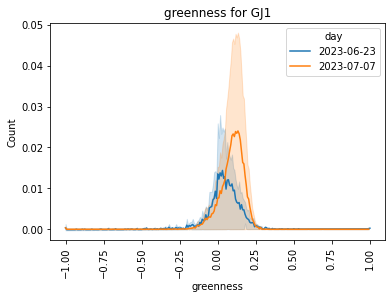

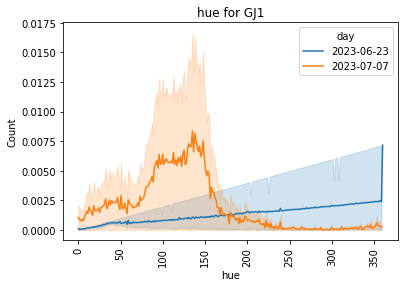

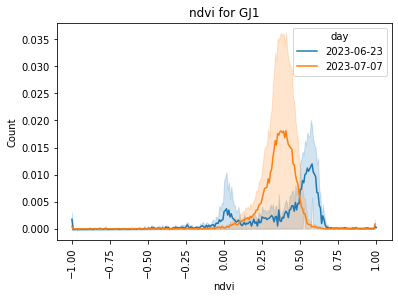

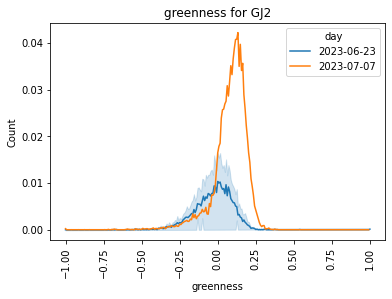

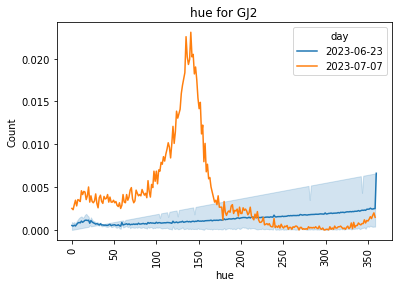

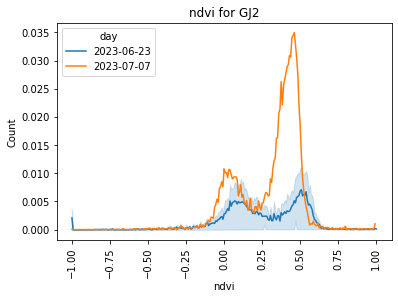

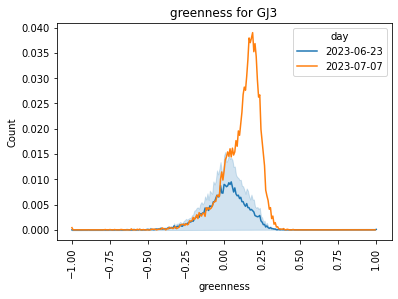

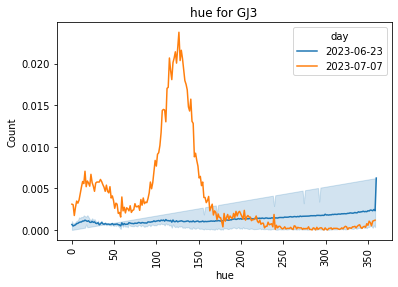

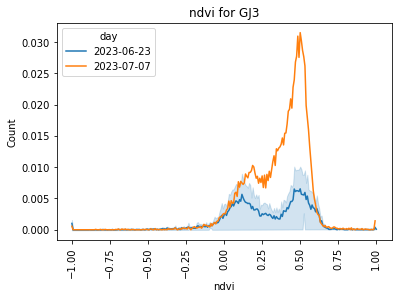

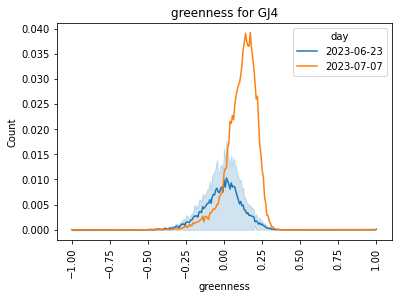

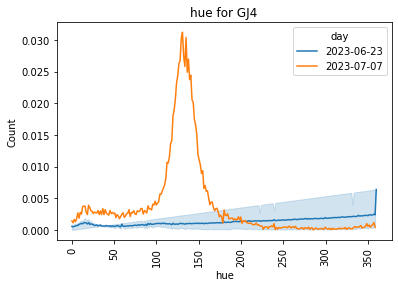

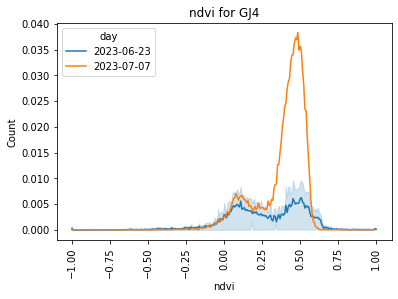

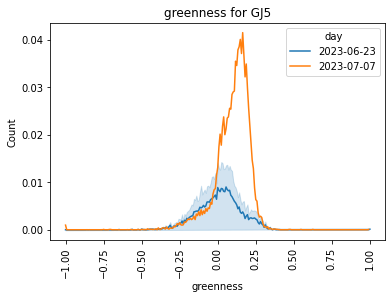

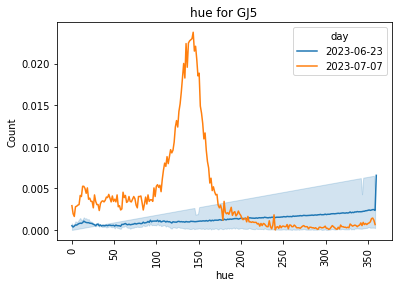

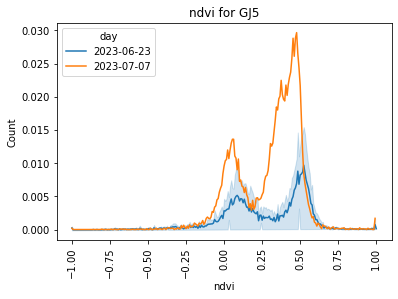

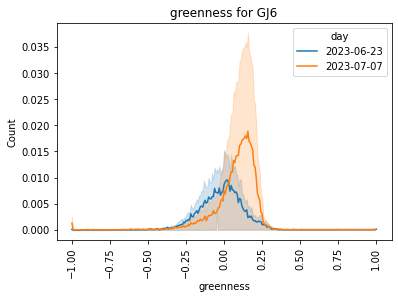

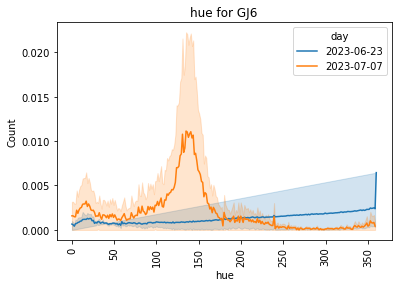

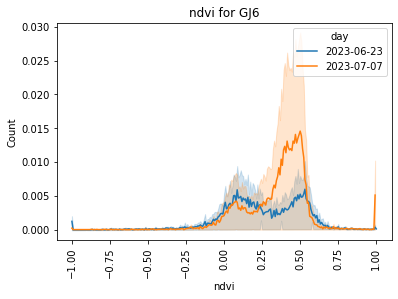

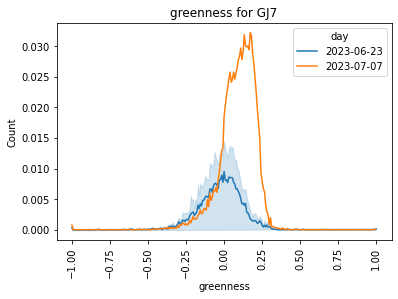

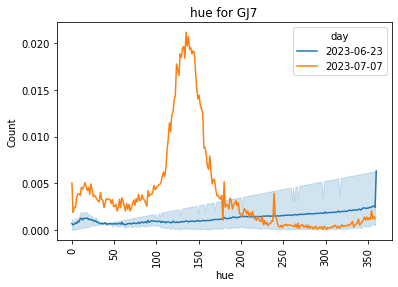

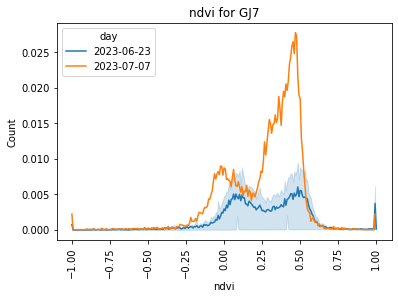

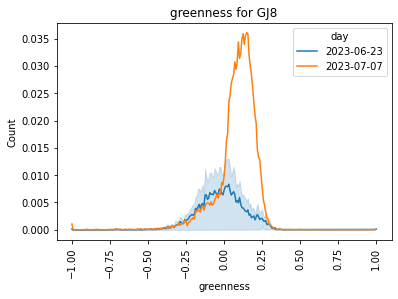

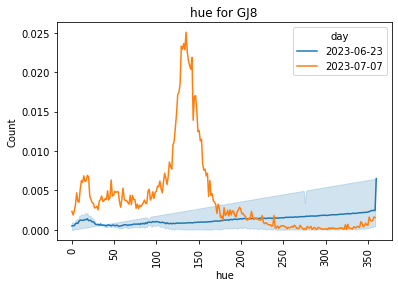

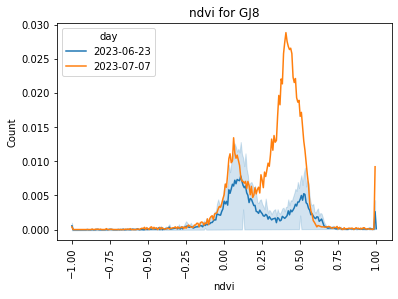

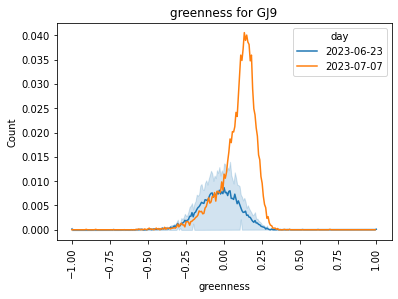

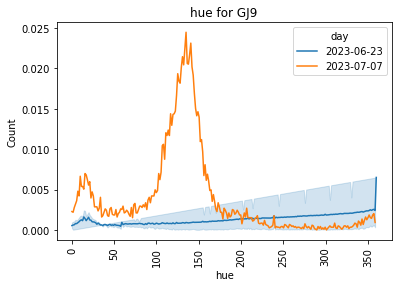

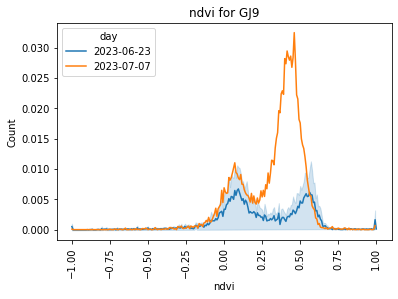

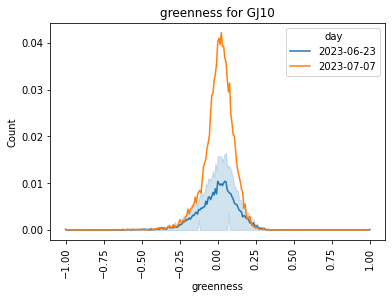

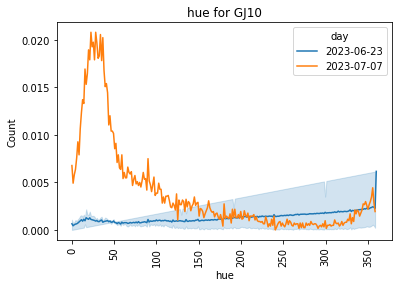

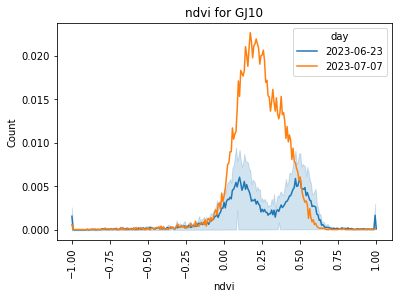

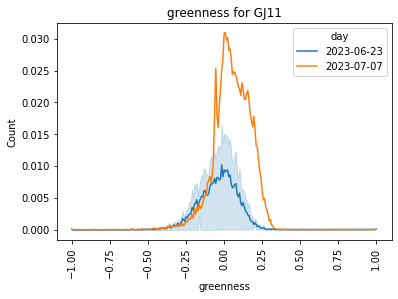

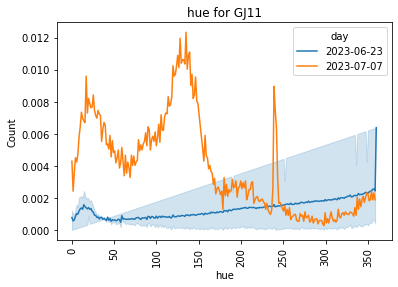

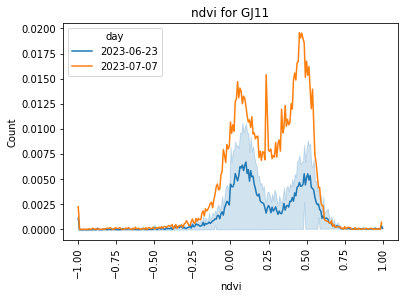

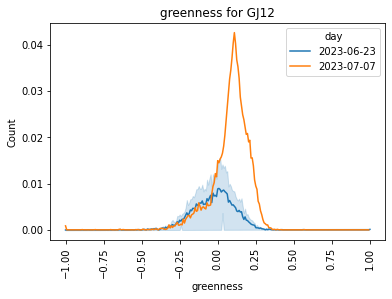

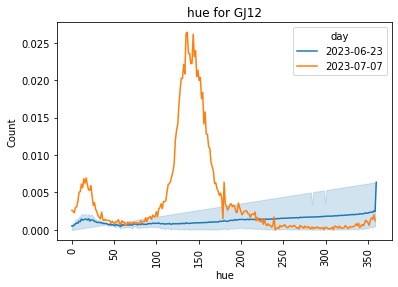

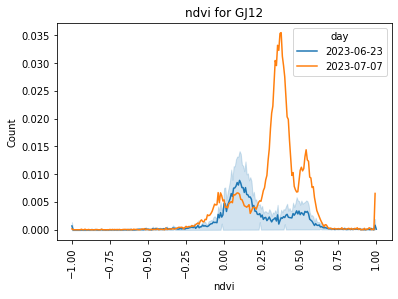

In [10]:
for sample_name in phenotypic_data["Pot"].unique():
    for index in ["greenness", "hue", "ndvi"]:
        sample = get_histogram(index, sample_name)
        plotHistogram(sample, index)




## Overview of top view images

This function is designed to **load and display top-view images** of 3D point clouds, either **RGB** or **NDVI-rendered**, for a given plant sample across multiple timepoints.

---

## 🌄 **Top-View Image Display Function**

### 🧩 Function: `get_images(type="RGB", sample=None)`

#### 🔧 **Purpose**

This function loads and displays a **series of top-view images** (either **RGB** or **NDVI**) of a selected plant sample over time. These images are generated from 3D point clouds collected by the **PlantEye F500**, and they provide a visual reference of plant structure and health.

---

### 📥 **Inputs**

* `type`: Type of image to load.

  * `"RGB"` (default): Standard color image generated from the point cloud.
  * `"NDVI"` or `"ndvi"`: False-color NDVI image showing vegetation health.
* `sample`: (Optional) A specific plant (pot) name. If left `None`, the function processes **all samples**.

---

### 🔍 **How It Works**

1. **Loop through each assay** (i.e., each timepoint and sample):

   * Extract sample name and timepoint (timestamp).
   * Check if the image file exists for the desired `type` (`.png` for RGB, `.ndvi.PNG` for NDVI).
   * Identify matching file paths using metadata from the ISA-JSON structure.
   * Append image file information (path and date) to a list.

2. **Filter valid files only**:

   * Ensures only existing image files (on disk) are included.

3. **Sort images by date**:

   * Converts timestamp strings to `datetime` and sorts chronologically.

4. **Prepare and display images using matplotlib**:

   * Dynamically adjusts grid size based on number of images.
   * Resizes each image for consistent display.
   * Disables axes for a cleaner look.
   * Shows the full set of time-sequenced top-view images.

---

### 🖼️ **What You’ll See**

* A **grid of images**, one for each scan of the selected plant (or all plants, if no sample is specified).
* Each image represents a **top-down view** of the plant at a specific timepoint.
* If `type="NDVI"`, the images use a color scale to show vegetation index intensity (e.g., green = healthy, red/yellow = stressed).
* Useful for visual inspection of **plant development** or **treatment effects** over time.

---

### 🧪 **Example Use Cases**

```python
get_images(type="RGB", sample="Pot_101")
```

Displays **RGB top views** of `Pot_101` over the experiment timeline.

```python
get_images(type="NDVI")
```

Displays **NDVI top views** for all samples (if present), sorted by scan date.

---

### 🌱 **Why This Is Useful**

* **Visual context**: Complements numeric trait data with qualitative visual cues.
* Helps detect **outliers**, damage, or scanner issues.
* Facilitates quick comparisons between RGB appearance and NDVI health signals.
* Valuable for **presentations**, **quality control**, and **hypothesis generation**.



In [11]:
def get_images(type = "RGB", sample = None):
    image = pd.DataFrame(columns=["date", "name"])
    for assay in study.assays:
        sample_name = assay.samples[0].name
        timepoint = assay.filename
        extension = ".png"
        if type in ["NDVI", "ndvi"]:
            extension = ".ndvi.PNG"
        if sample != None:
            if sample_name != sample:
                continue
        for df in assay.data_files:
            for com in df.comments:
                if "ply.gz" in com.value and "full" in com.value:
                    new_row = pd.DataFrame([{
                        "date": timepoint,
                        "name": data_folder + com.value + extension}])

                    image = pd.concat([image, new_row], ignore_index=True)
                    #print("Found image file: {}".format(com.value))
    image = image[image["name"].apply(lambda x: os.path.exists(x))].reset_index(drop=True)
    # Convert 'date' column to datetime for sorting
    image['date'] = pd.to_datetime(image['date'], format='%Y%m%dT%H%M%S')

    # Sort the dataframe by date
    image = image.sort_values(by='date')

    # Extract all the file names
    image_files = image['name'].tolist()


    max_cols = 5
    num_images = len(image_files)

    # Calculate number of rows needed
    rows = math.ceil(num_images / max_cols)
    cols = min(num_images, max_cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    # If there's only 1 row, axes is 1D; make it 2D for consistency
    if rows == 1:
        axes = [axes]

    # Flatten axes to 1D list for easy indexing
    axes_flat = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

    # Display images
    for i, ax in enumerate(axes_flat):
        if i < num_images:
            img = Image.open(image_files[i])
            img.thumbnail((200, 200))
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplot axes

    plt.tight_layout()
    plt.show()


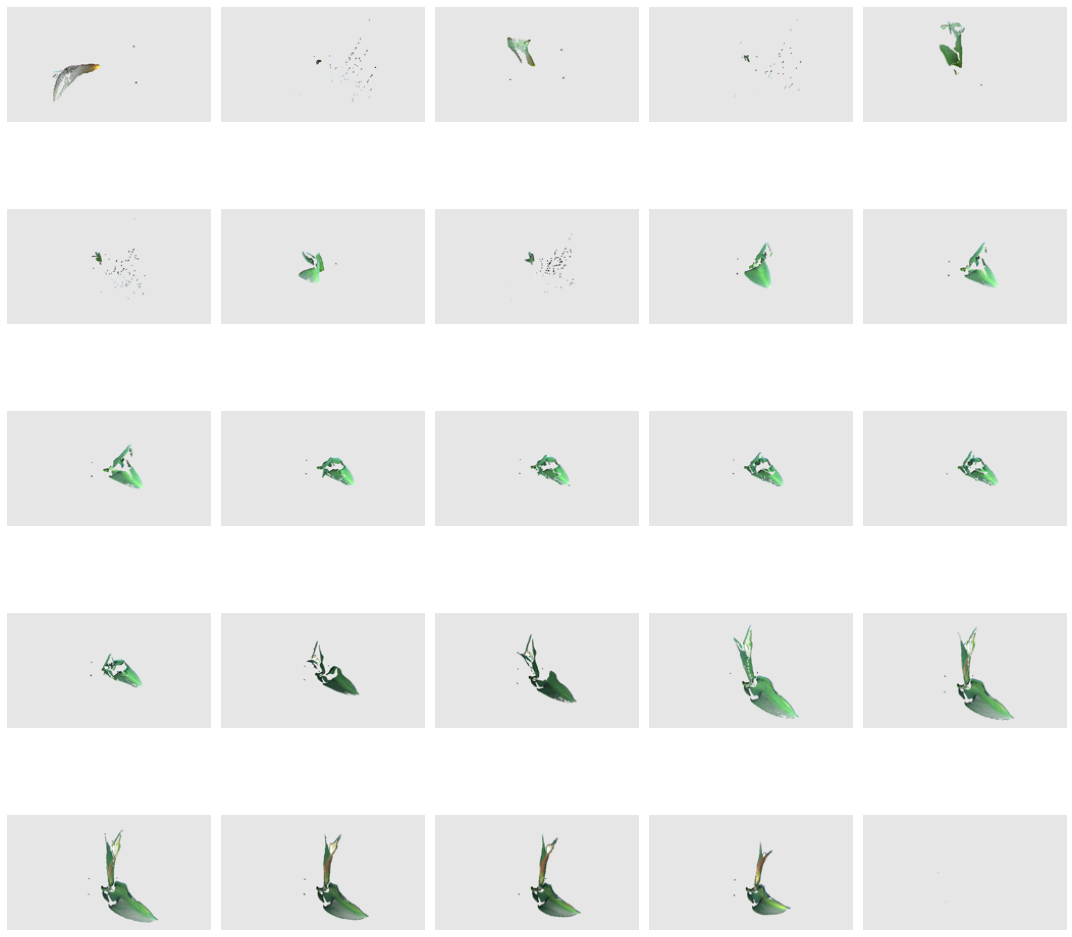

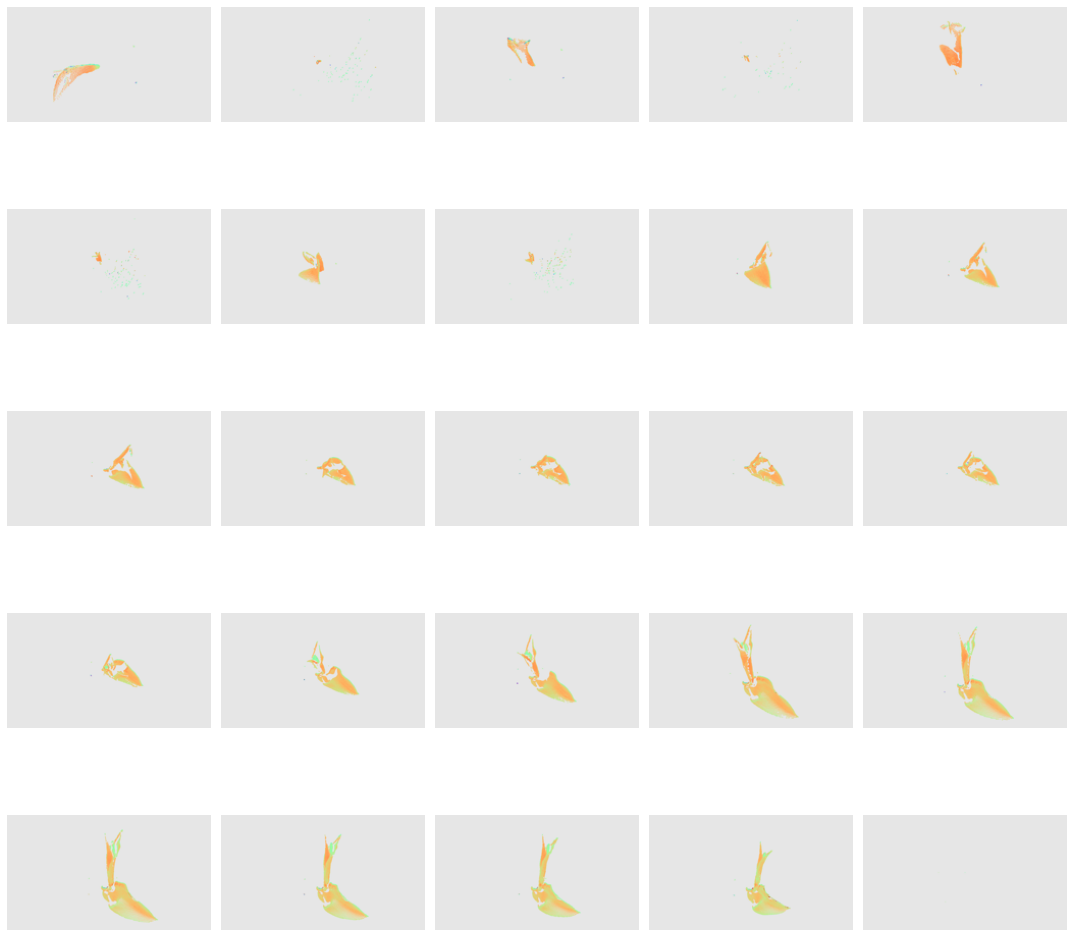

In [12]:
get_images("RGB",  "GJ1")
get_images("ndvi",  "GJ1")

## 🌱 **Plant Vigor: What It Is and How It's Measured**

### 🌿 **What Is Plant Vigor?**

**Plant vigor** refers to the **rate of growth** or **growth potential** of a plant over time. It reflects how rapidly a plant is accumulating biomass, which can be influenced by:

* Genetics (e.g., genotype differences)
* Environmental conditions (light, temperature, soil)
* Treatments (fertilization, drought, etc.)

In high-throughput phenotyping (like with the PlantEye F500), **vigor is typically derived from changes in digital biomass over time**.

---

## 📈 **What This Code Does: Calculating and Plotting Vigor**

This section calculates plant vigor based on **digital biomass measurements** over time and visualizes both the **growth rate (vigor)** and the **biomass accumulation** itself.

---

### 🧩 **Step-by-Step Code Documentation**

#### 1. **Select a Sample Plant**

```python
sample = "GJ1"
vigor = phenotypic_data[phenotypic_data['Pot'] == sample].sort_values(by=['Pot', 'timestamp'])
```

* Filters the dataset to include only measurements for a specific plant pot (`GJ1`).
* Sorts the data by timestamp to ensure it's in chronological order.

---

#### 2. **Define Time Resolution for Smoothing**

```python
resample_interval = '12h'
```

* Sets the time resolution to **12-hour intervals**.
* This controls how often we calculate estimated biomass values by interpolation.

---

#### 3. **Resample and Interpolate Biomass**

```python
def interpolate_biomass(df):
    ...
```

* This function:

  * **Resamples the biomass values** at uniform time intervals (12 hours).
  * **Interpolates missing values** using a 3rd-order polynomial, smoothing the curve.
  * **Applies a rolling average** to reduce noise.
* The result is a **smoothed, continuous digital biomass curve** over time.

---

#### 4. **Apply the Interpolation**

```python
df_interpolated = interpolate_biomass(vigor)
```

* Applies the above function to the sample's data.

---

#### 5. **Calculate Growth Rate (Vigor)**

```python
df_interpolated['time_change'] = ...
df_interpolated['biomass_change'] = ...
df_interpolated['vigor'] = df_interpolated['biomass_change'] / df_interpolated['time_change']
```

* Computes the **time difference** between each measurement (in hours).
* Calculates how much **biomass has changed** between timepoints.
* Divides biomass change by time difference → this is **vigor** (biomass gain per hour).
* Applies smoothing to biomass change to handle measurement noise.

---

#### 6. **Clean and Visualize**

```python
df_interpolated = df_interpolated.dropna(...)
plt.plot(df_interpolated['timestamp'], df_interpolated['vigor'], ...)
```

* Removes initial `NaN` values that result from `.diff()` (which calculates change).
* Plots **vigor over time** (how fast the plant is growing).
* Then plots **digital biomass over time** (how much biomass has accumulated).

---

## 🔍 **What You Learn From the Plots**

* **Vigor Plot**: Helps identify when the plant was growing fastest (high vigor) and when growth slowed or stopped (low/zero vigor).
* **Biomass Plot**: Shows the overall **growth curve** of the plant over the course of the experiment.

Together, they give a **dynamic picture** of growth — not just the final size, but **how and when** growth occurred.

---

### 🧪 Example Applications

* Compare **vigor patterns across genotypes** or treatments.
* Identify **critical growth periods** (e.g., early vigor boost under fertilizer).
* Detect **growth slowdowns** due to stress or senescence.



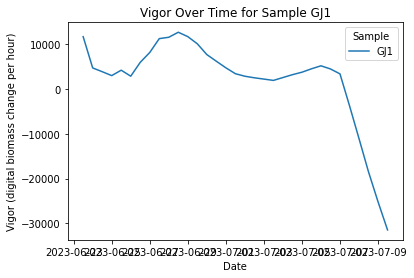

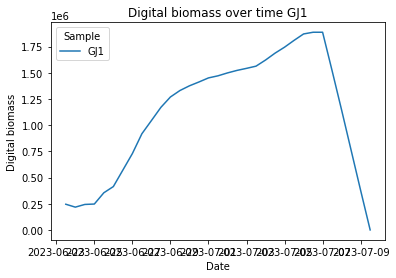

In [13]:
# Sample to calculate vigor for
sample = "GJ1"

# Filter data for the specific sample and sort by 'timestamp'
vigor = phenotypic_data[phenotypic_data['Pot'] == sample].sort_values(by=['Pot', 'timestamp'])

# Define the time interval for interpolation (e.g., every 1 hour)
resample_interval = '12h'  # or '6H', '12H', etc. depending on the desired frequency

# Function to interpolate biomass for a single sample
def interpolate_biomass(df):
    # Set 'timestamp' as the index to allow resampling
    df = df.set_index('timestamp')

    # Resample biomass at the defined interval and interpolate missing values
    resampled_df = df[['digital_biomass']].resample(resample_interval).mean()  # Resample every X hours

    # Interpolate only the 'digital_biomass' column
    resampled_df['digital_biomass'] = resampled_df['digital_biomass'].interpolate(method='polynomial', order=3)
    resampled_df['digital_biomass'] = resampled_df['digital_biomass'].rolling(window=5, min_periods=1).mean()

    # Forward fill 'Pot' (non-numeric column)
    resampled_df['Pot'] = df['Pot'].ffill()

    # Reset index to return to the original structure
    return resampled_df.reset_index()

# Directly apply interpolation without using apply() (since we're working with a single sample)
df_interpolated = interpolate_biomass(vigor)

# Calculate the time difference (in hours) between consecutive time points
df_interpolated['time_change'] = df_interpolated['timestamp'].diff().dt.total_seconds() / 3600.0

# Calculate the biomass change
df_interpolated['biomass_change'] = df_interpolated['digital_biomass'].diff()
df_interpolated['biomass_change'] = df_interpolated['biomass_change'].interpolate(method='polynomial', order=3)
df_interpolated['biomass_change'] = df_interpolated['biomass_change'].rolling(window=5, min_periods=1).mean()

# Calculate vigor (biomass change per hour)
df_interpolated['vigor'] = df_interpolated['biomass_change'] / df_interpolated['time_change']

# Drop NaN values created by diff() in the first row
df_interpolated = df_interpolated.dropna(subset=['time_change', 'biomass_change'])

# Plot the vigor over time for the sample
plt.plot(df_interpolated['timestamp'], df_interpolated['vigor'], label=sample)
plt.xlabel('Date')
plt.ylabel('Vigor (digital biomass change per hour)')
plt.title(f'Vigor Over Time for Sample {sample}')
plt.legend(title='Sample')
plt.show()

# Plot the biomass over time for the sample
plt.plot(df_interpolated['timestamp'], df_interpolated['digital_biomass'], label=sample)
plt.xlabel('Date')
plt.ylabel('Digital biomass')
plt.title(f'Digital biomass over time {sample}')
plt.legend(title='Sample')
plt.show()
